<img src="https://geekandchic.cl/wp-content/uploads/2016/06/Desafio-Latam-Logo-alta-resoluci%C3%B3n-1.jpg" alt="logo" style="width: 170px" align="right" hspace="10"/>

## Métodos de regularización lineal y expansiones basales
## Actividad 1: Regularización
### Sebastián Contreras Zambrano

* Para poder realizar esta actividad debes haber revisado la lectura correspondiente a la semana.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminada la actividad, comprime la carpeta y sube el .zip a la sección correspondiente.

## Descripción de la actividad

* En esta ocasión utilizaremos datos de la composición química de muestras de vino.
* Nuestro propósito será tratar de predecir su calidad a partir de su composición química.
* Comience su estudio realizando un breve análisis exploratorio y descriptivo:
    * Identifique el tipo de datos de cada columna.
    * Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.
    * Encuentre la cantidad de valores faltantes en cada columna.
    * Grafique la distribución empírica de cada atributo

## Ejercicio 1: Preparación del Ambiente de Trabajo

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Ejercicio 2: Análisis exploratorio

* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.

In [4]:
def inspeccion_datos(dataframe):
    """
    Esta función retorna las medias descriptivas para los variables continuos y la frecuencia para las variables discretas.
    Recibe como argumento un dataframe de pandas
    """
    for colname,serie in dataframe.iteritems():
        if pd.api.types.is_numeric_dtype(serie):
            print('"{}" es una variable continua, y su descripción es:'.format(colname))
            print('-----------')
            print(serie.describe())
            print('')
        else:
            frec=serie.value_counts('%')
            print('"{}" es una variable discreta, y su frecuencia es:'.format(colname))
            print('-----------')
            print(frec)
            print('')

### Conocer dataset

In [5]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
inspeccion_datos(df)

"fixed acidity" es una variable continua, y su descripción es:
-----------
count    1599.000000
mean        8.319637
std         1.741096
min         4.600000
25%         7.100000
50%         7.900000
75%         9.200000
max        15.900000
Name: fixed acidity, dtype: float64

"volatile acidity" es una variable continua, y su descripción es:
-----------
count    1599.000000
mean        0.527821
std         0.179060
min         0.120000
25%         0.390000
50%         0.520000
75%         0.640000
max         1.580000
Name: volatile acidity, dtype: float64

"citric acid" es una variable continua, y su descripción es:
-----------
count    1599.000000
mean        0.270976
std         0.194801
min         0.000000
25%         0.090000
50%         0.260000
75%         0.420000
max         1.000000
Name: citric acid, dtype: float64

"residual sugar" es una variable continua, y su descripción es:
-----------
count    1599.000000
mean        2.538806
std         1.409928
min         0.90000

### Revisar missing data

<Figure size 360x360 with 0 Axes>

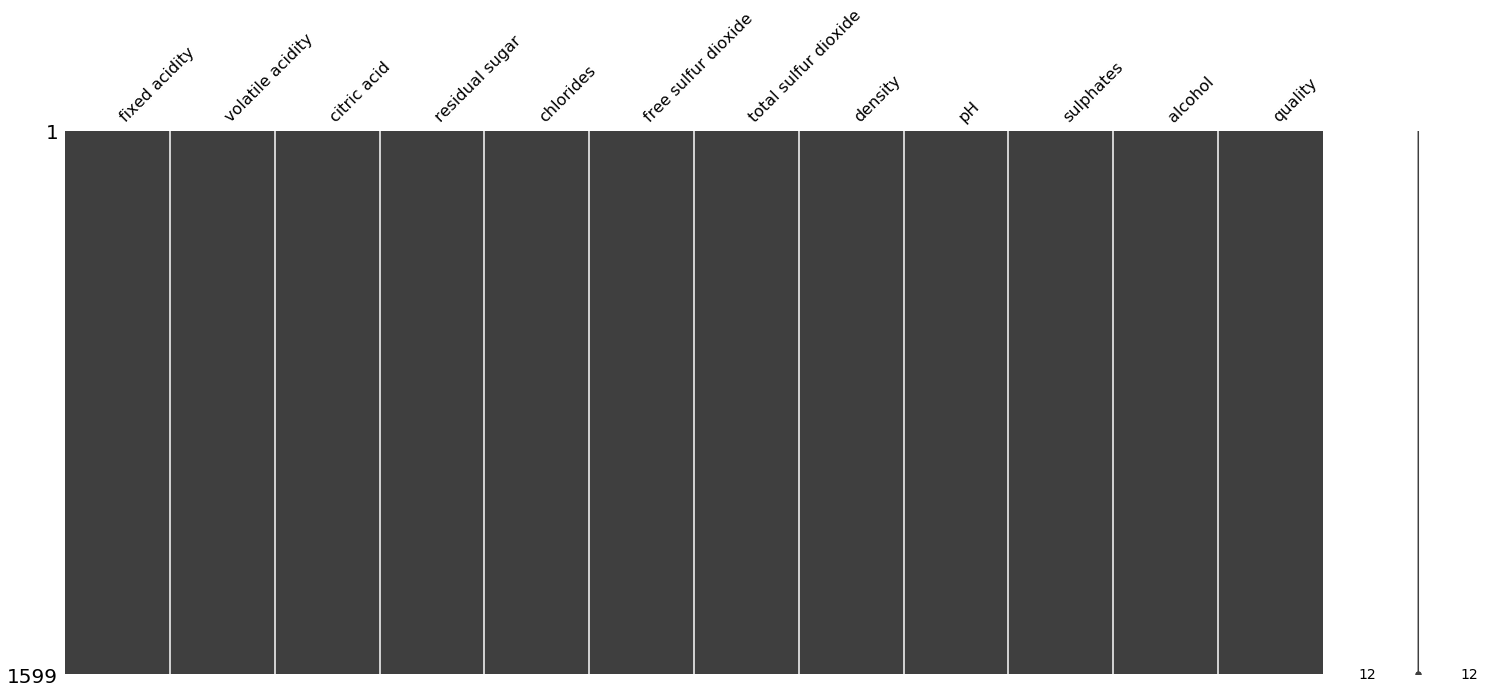

In [10]:
plt.figure(figsize=(5,5))
miss.matrix(df);

In [11]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

No se existe missing data en el dataset

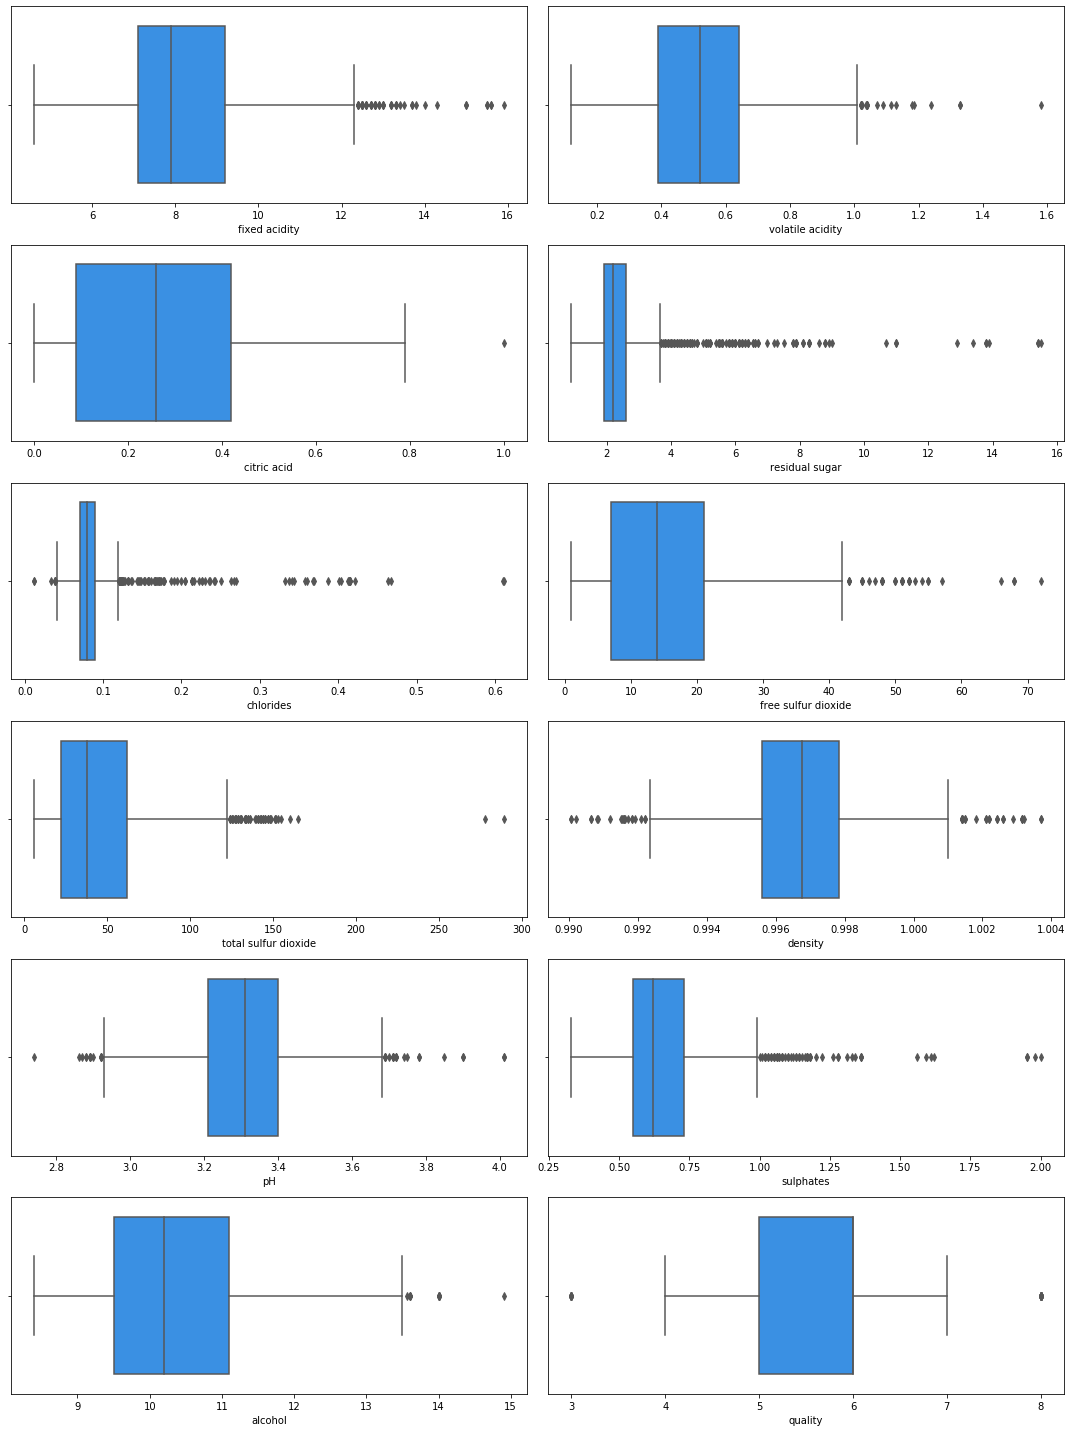

In [15]:
plt.figure(figsize=(15,20))
for index, (colname, serie) in enumerate (df.iteritems()):
    plt.subplot(6, 2, index+1)
    sns.boxplot(serie, color='dodgerblue')
    plt.tight_layout()

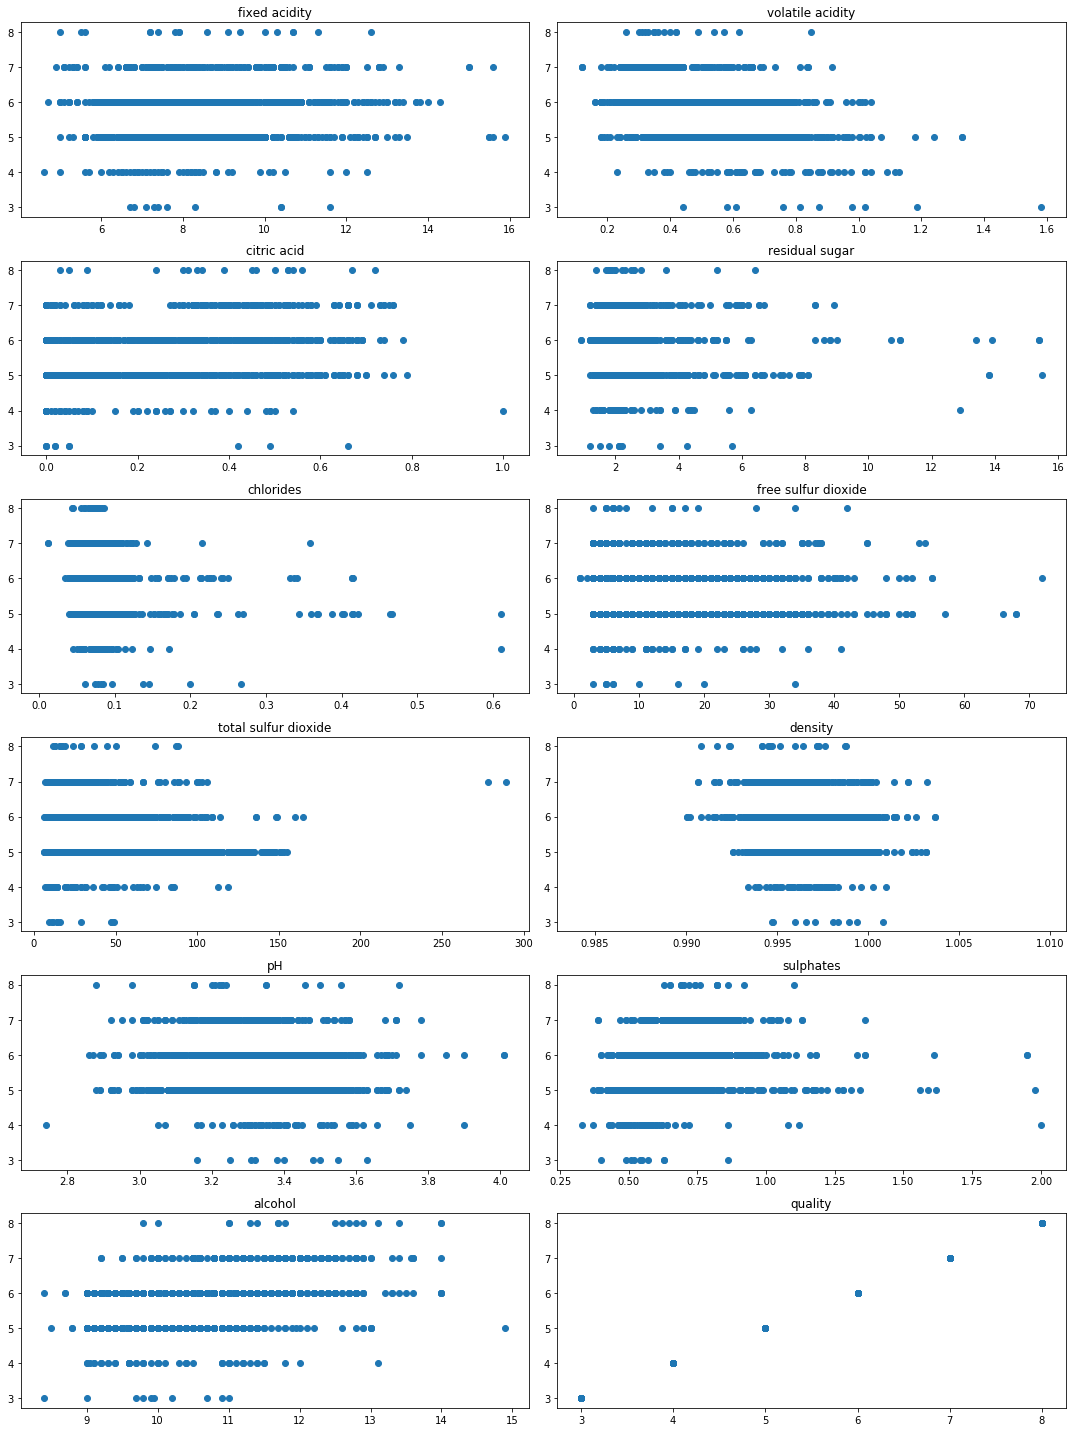

In [13]:
plt.figure(figsize=(15,20))
for index, (colname, serie) in enumerate (df.iteritems()):
    plt.subplot(6, 2, index+1)
    plt.scatter(x=df[colname], y=df['quality'])
    plt.title(colname)
    plt.tight_layout()

# Ejercicio 3: Regularización de modelos
* Genere tres modelos, correspondientes a `RidgeCV`, `LassoCV` y `ElasticNetCV`. Para cada uno de ellos implemente los siguientes pasos:
    * Entrene los modelos con 10 validaciones cruzadas.
    * Extraiga los coeficientes estimados, el mejor valor alpha, MAE(`median_absolute_error`) y RMSE (`mean_squared_error`) asociado a cada modelo.
    * En base a la información solicitada, responda lo siguiente:
    * ¿Qué modelo presenta un mejor desempeño en base a las métricas?
    * ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

In [16]:
#estandarizar atributos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='quality', axis=1))

#separar atributos
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['quality'], test_size = 0.3, random_state=250992)

In [17]:
# LassoCV
lassoCV_model = LassoCV(cv=10).fit(X_train, y_train)

# RidgeCV
ridgeCV_model = RidgeCV(cv=10).fit(X_train, y_train)

#Elastic Net
enetCV_model = ElasticNetCV(cv=10).fit(X_train, y_train)

In [31]:
# MAE
print(f"LassoCV MAE: {mean_absolute_error(lassoCV_model.predict(X_test), y_test)}")
print(f"ridgeCV_model MAE: {mean_absolute_error(ridgeCV_model.predict(X_test), y_test)}")
print(f"enetCV_model MAE: {mean_absolute_error(enetCV_model.predict(X_test), y_test)}")

LassoCV MAE: 0.5041014844948312
ridgeCV_model MAE: 0.5028924480627402
enetCV_model MAE: 0.5040527626349148


In [24]:
# MSE
print(f"LassoCV MSE: {mean_squared_error(lassoCV_model.predict(X_test), y_test)}")
print(f"ridgeCV_model MSE: {mean_squared_error(ridgeCV_model.predict(X_test), y_test)}")
print(f"enetCV_model MSE: {mean_squared_error(enetCV_model.predict(X_test), y_test)}")

LassoCV MSE: 0.4103138845335072
ridgeCV_model MSE: 0.40894895803687764
enetCV_model MSE: 0.41007842379060844


En base a los resultados obtenidos, se puede apreciar que el modelo `ridgeCV` tiene una métrica más baja de __MAE__ y __MSE__, por lo cual, se puede observar que este modelo presenta un mejor desempeño en base a las métricas obtenidas.

In [26]:
columnas = []
for colname in df:
    if colname != "quality":
        columnas.append(colname)

In [27]:
df_lasso = pd.DataFrame(data=lassoCV_model.coef_,index=columnas)
df_ridge = pd.DataFrame(data=ridgeCV_model.coef_,index=columnas)
df_enet = pd.DataFrame(data=enetCV_model.coef_,index=columnas)

df_lasso = df_lasso.rename(columns={0: 'df_lasso'})
df_ridge = df_ridge.rename(columns={0: 'df_ridge'})
df_enet = df_enet.rename(columns={0: 'df_enet'})

df_models = pd.concat([df_lasso, df_ridge, df_enet], axis=1, sort=False)
display(df_models)

,df_lasso,df_ridge,df_enet
fixed acidity,0.018321,0.058675,0.019715
volatile acidity,-0.204021,-0.208081,-0.203300
citric acid,-0.027488,-0.049051,-0.027080
residual sugar,0.000000,0.012371,0.000000
chlorides,-0.049814,-0.053585,-0.050296
free sulfur dioxide,0.033564,0.045564,0.034168
total sulfur dioxide,-0.080148,-0.089183,-0.080654
density,-0.000000,-0.032825,-0.001011
pH,-0.073323,-0.068723,-0.072396
sulphates,0.113966,0.124343,0.114237


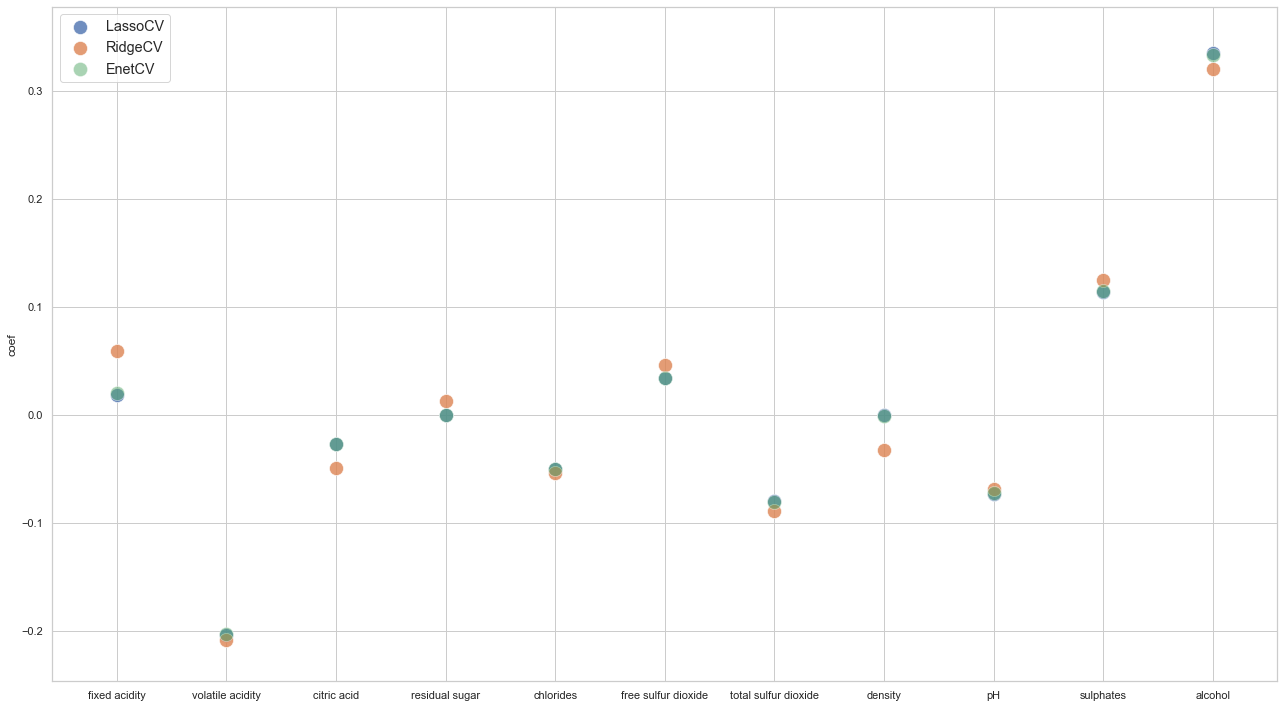

In [28]:
plt.figure(figsize=(18,10))
sns.set(style="whitegrid")
sns.scatterplot(x=columnas, y=df_lasso['df_lasso'], palette='dodgerblue', s=200, alpha=.8)
sns.scatterplot(x=columnas, y=df_ridge['df_ridge'], palette='tomato', s=200, alpha=0.8);
c= sns.scatterplot(x=columnas, y=df_enet['df_enet'], palette='forestgreen', s=200, alpha=0.5);
c.set(ylabel='coef')
plt.legend(['LassoCV', 'RidgeCV', 'EnetCV'], fontsize='large')
plt.tight_layout()

Los atributos que mantienen un comportamiento similar en los tres modelos entrenados, son los siguientes:

| atributo|df_lasso | df_ridge | df_enet |
| ---| --- | --- | --- |
| __volatile acidity__ | -0.204021 | -0.208081 | -0.203300 |
| __residual sugar__ | 0.000000 | 0.012371  | 0.000000 |
| __chlorides__ | -0.049814 | -0.053585 | -0.050296 |
| __free sulfur dioxide__ | 0.033564 | 0.045564 | 0.034168 |
| __total sulfur dioxide__ | -0.080148 | -0.089183 | -0.080654 |
| __density__ | -0.000000 | -0.032825 | -0.001011 |
| __pH__ | -0.073323 | -0.068723 | -0.072396 |
| __sulphates__ | 0.113966 | 0.124343 | 0.114237 |
| __alcohol__ | 0.334917 | 0.319966 | 0.332926 |


En evidencia con la tabla anteriormente expuesta, se puede observar que en general, gran parte de los atributos presentan variaciones marginales en los coeficientes respecto a los modelos de Ridge, Lasso y Elastic Net, los cuales fueron entrenados con Validación Cruzada de 10 iteraciones. El único atributo que presenta la mayor variabilidad de establidad es __`fixed acidity`__, con los siguientes valores:

| atributo|df_lasso | df_ridge | df_enet |
| ---| --- | --- | --- |
| __fixed acidity__ | 0.018321 | 0.058675 | 0.019715 |
